In [18]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, norm

In [20]:
# Load the Excel file and process data
file_path = 'Output_Parameters_Assembly.xlsx'
sheet_name = 'AnglesBetweenTopAndBottomPlane'
df = pd.read_excel(file_path, sheet_name=sheet_name)

In [21]:
def process_data(value):
    value = value.replace('.xlsx', '')
    value = re.sub(r'(T|S|B|590|-)', '', value)
    split_data = re.split(r'(_|(?<=[a-zA-Z])(?=\d)|(?<=\d)(?=[a-zA-Z]))', value)
    split_data = [x for x in split_data if x not in ['_', '']]
    return split_data

In [26]:
# Apply processing function to the input column
df['Processed_Column'] = df.iloc[:, 0].apply(process_data)

# Extract numerical values from the Processed_Column and convert them to features
def extract_numeric_features(row):
    return [
        float(x) if x.isdigit() or x.replace('.', '', 1).isdigit() 
        else 100 if x == "DP" 
        else 200 if x == "AlNumi" 
        else 0  # default case for other non-numeric values
        for x in row
    ]


# Apply the function to create numerical features
X = df['Processed_Column'].apply(extract_numeric_features)

# Convert the feature list to a DataFrame (input matrix X)
X = pd.DataFrame(X.tolist())

# Output target column (Zone Size (mm))
y = df[['Alpha (Degrees)', 'Beta (Degrees)', 'Gamma (Degrees)']]
print(y)

      Alpha (Degrees)  Beta (Degrees)  Gamma (Degrees)
0           90.028254        0.052860         0.028529
1           89.766164        0.012856         0.526388
2           89.972711        0.031224         0.380290
3           89.849230        0.001808         0.099243
4           90.077248        0.022922         2.914879
...               ...             ...              ...
999         89.938733        0.052896         0.473260
1000        90.103577        0.003736         0.008644
1001        90.340810        0.079387         2.785299
1002        89.628586        0.012830         2.665843
1003        90.043155        0.070070         3.013824

[1004 rows x 3 columns]


In [27]:
# Step 5: Remove the 2nd and 8th columns from X (Note: Python is 0-indexed)
X = X.drop(columns=[1, 7]) 
X.columns = [
    "Channel_Width_T",
    "material 100:DP590 200:AlNumi_T",
    "Thickness_T",
    "Draw_Depth_T",
    "Blank_Holding_Force_T",
    "Channel_Width_B",
    "material 100:DP590 200:AlNumi_B",
    "Thickness_B",
    "Draw_Depth_B",
    "Blank_Holding_Force_B",
    "Weld_Pattern(1,2 = 4,3 welds/flange)"
]
print(X)

      Channel_Width_T  material 100:DP590 200:AlNumi_T  Thickness_T  \
0                50.0                              100        100.0   
1                45.0                              200        150.0   
2                55.0                              100        100.0   
3                60.0                              200        200.0   
4                50.0                              200        200.0   
...               ...                              ...          ...   
999              55.0                              200        100.0   
1000             45.0                              100        150.0   
1001             55.0                              200        150.0   
1002             45.0                              200        100.0   
1003             50.0                              100        150.0   

      Draw_Depth_T  Blank_Holding_Force_T  Channel_Width_B  \
0             52.5                15400.0             50.0   
1             57.5     

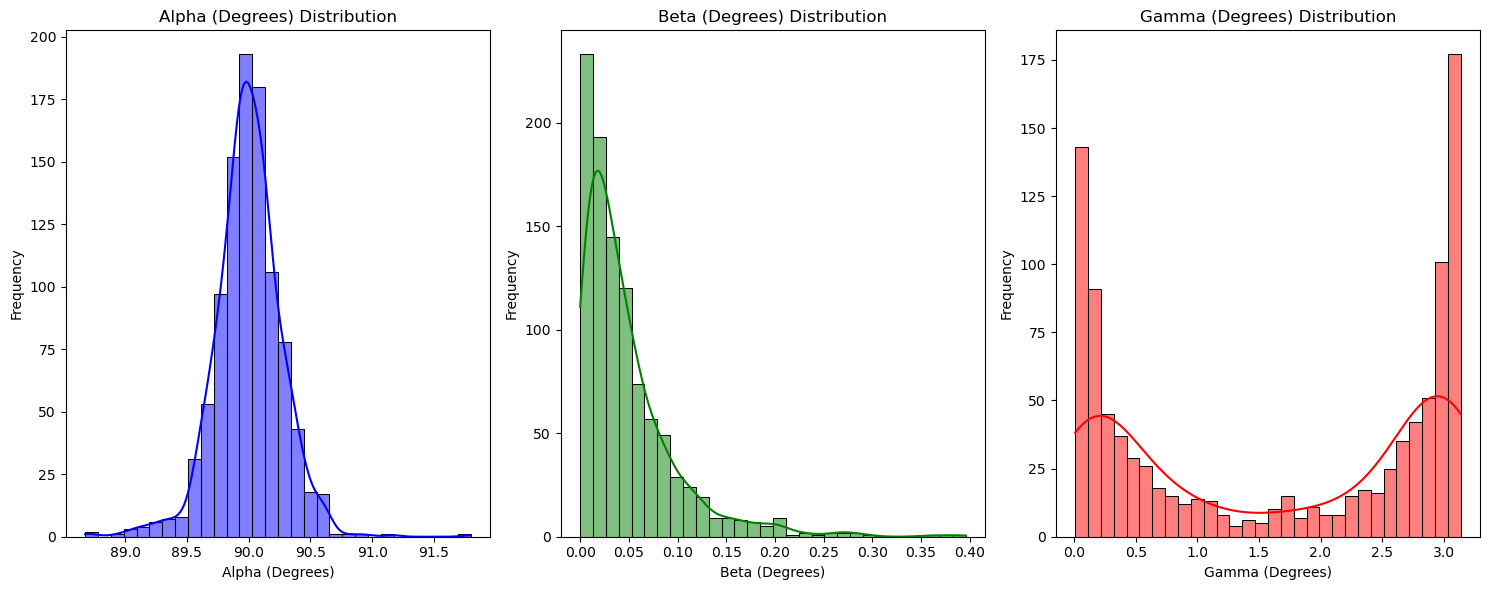

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_updated is the DataFrame that holds the target columns (y)
y_updated = y  # if y has been updated previously

# Step 1: Plot the distributions for each column in y (Alpha, Beta, Gamma)

# Create a figure with 3 subplots
plt.figure(figsize=(15, 6))

# Plot 1: Alpha (Degrees)
plt.subplot(1, 3, 1)
sns.histplot(y_updated['Alpha (Degrees)'], kde=True, bins=30, color='blue')
plt.title('Alpha (Degrees) Distribution')
plt.xlabel('Alpha (Degrees)')
plt.ylabel('Frequency')

# Plot 2: Beta (Degrees)
plt.subplot(1, 3, 2)
sns.histplot(y_updated['Beta (Degrees)'], kde=True, bins=30, color='green')
plt.title('Beta (Degrees) Distribution')
plt.xlabel('Beta (Degrees)')
plt.ylabel('Frequency')

# Plot 3: Gamma (Degrees)
plt.subplot(1, 3, 3)
sns.histplot(y_updated['Gamma (Degrees)'], kde=True, bins=30, color='red')
plt.title('Gamma (Degrees) Distribution')
plt.xlabel('Gamma (Degrees)')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()  # To ensure the subplots don't overlap
plt.show()


Training Loss (MSE): 0.6126617364403611
Test Loss (MSE): 0.9809093220138516


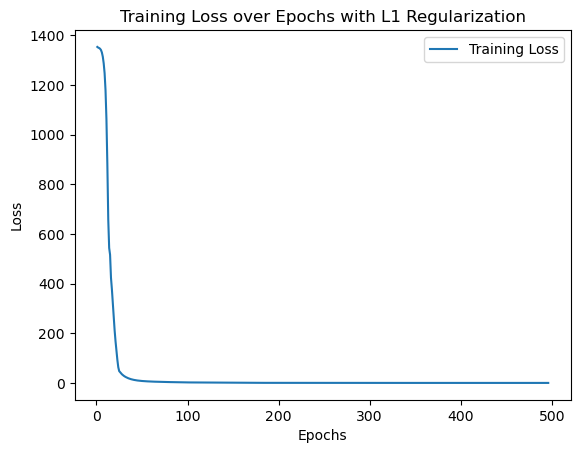

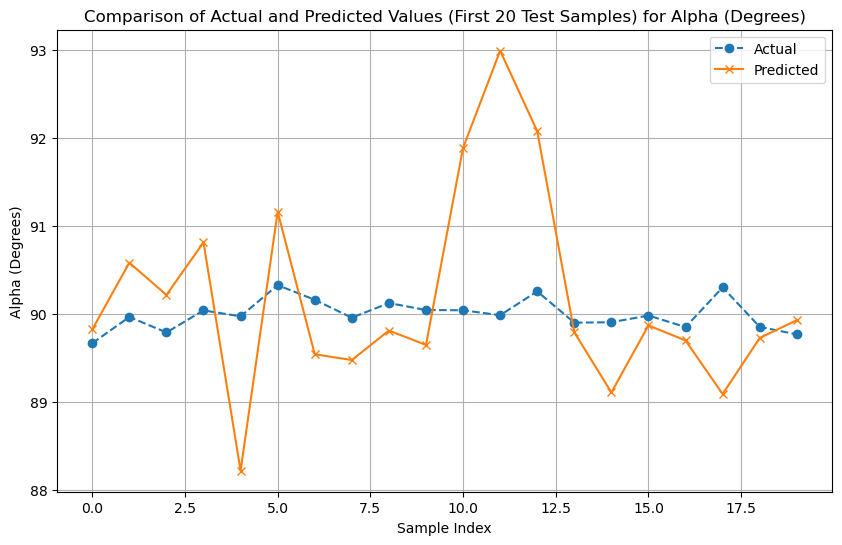

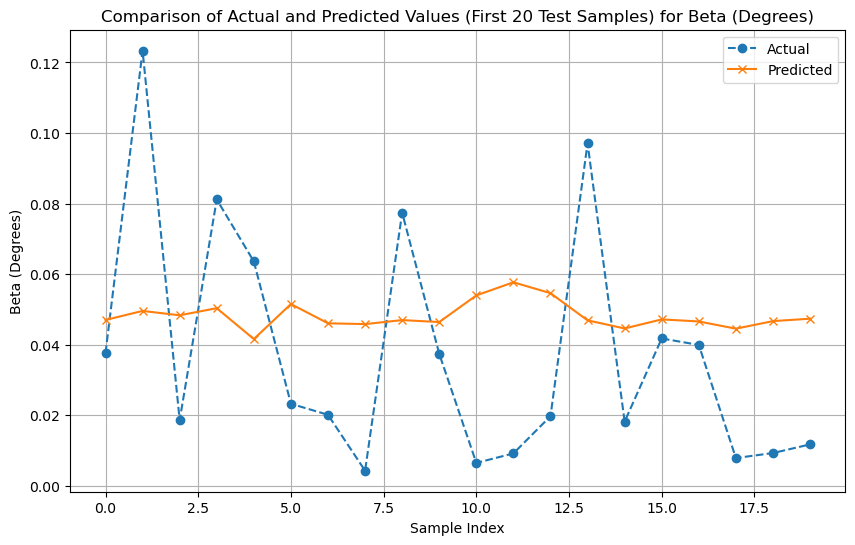

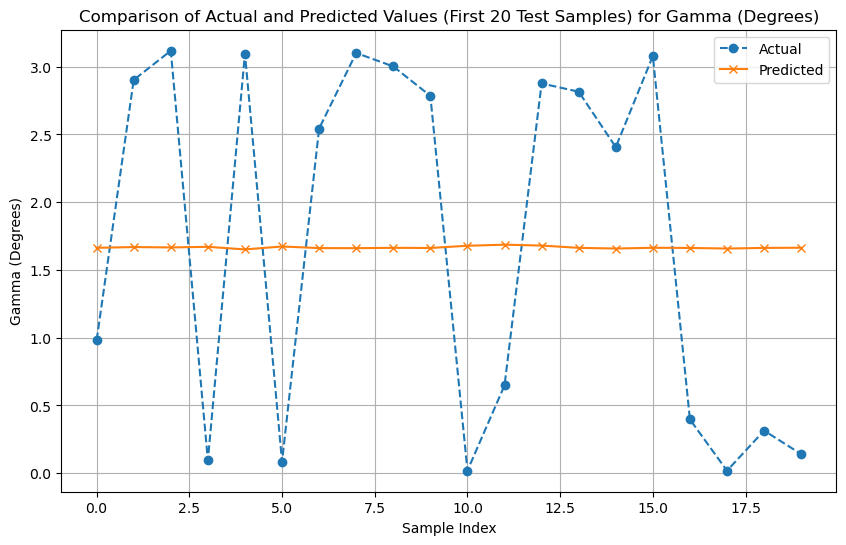

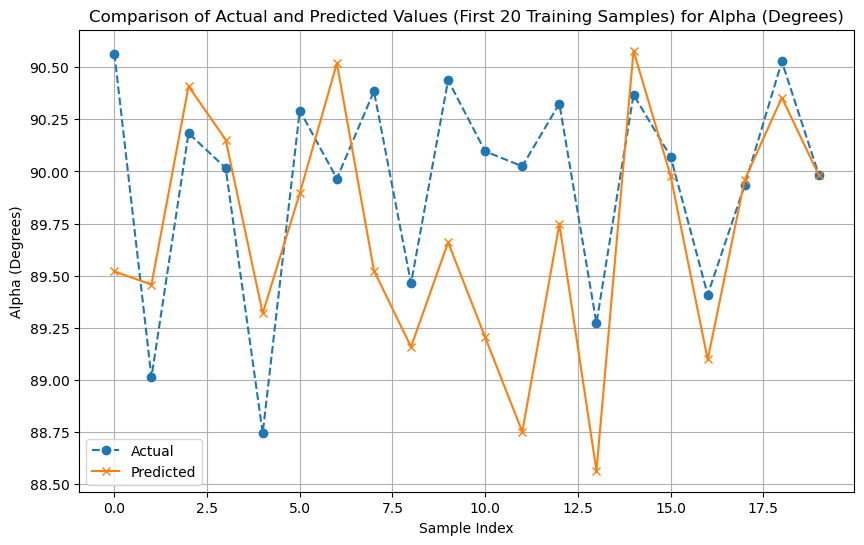

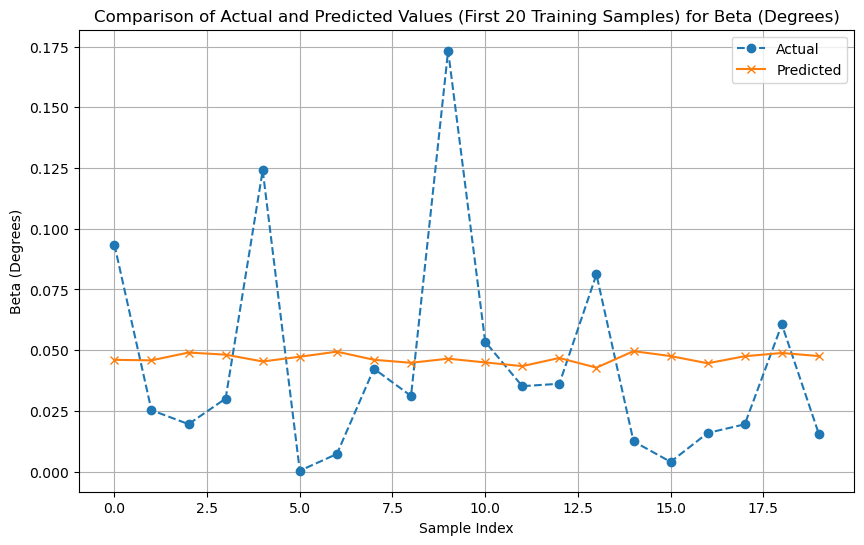

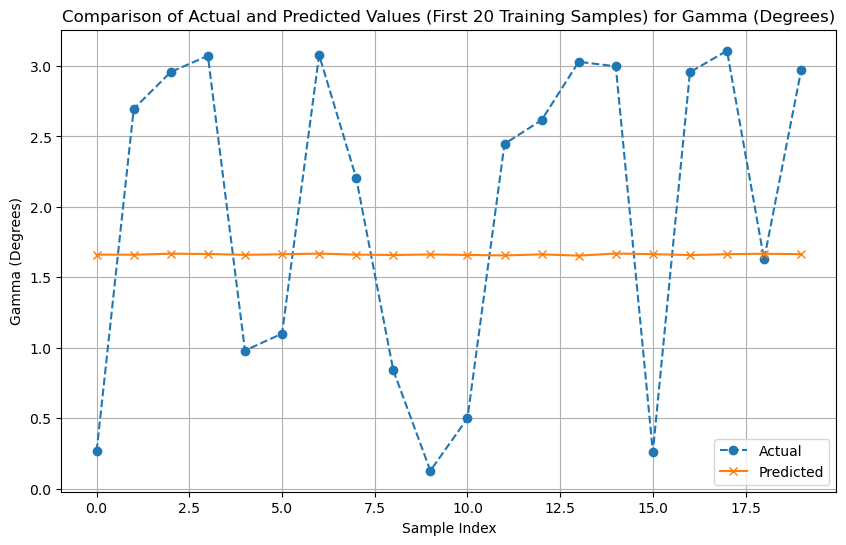

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Train-test split (90:10)
X_train, X_test, y_train, y_test = train_test_split(X, y_updated, test_size=0.1, random_state=42)

# Feature scaling for input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPRegressor(hidden_layer_sizes=(50, 50, 50, 20, 20, 20, 10, 10, 10, 5),
                   activation='relu',
                   solver='adam',
                   max_iter=5000,
                   random_state=42,
                   alpha=0.0001,  # L2 regularization
                   early_stopping=False,  # Enable early stopping
                   validation_fraction=0.1,  # Use 10% of training data for validation
                   n_iter_no_change=10) 

# Train the model
mlp.fit(X_train_scaled, y_train)

# Predictions and performance evaluation
y_train_pred = mlp.predict(X_train_scaled)
y_test_pred = mlp.predict(X_test_scaled)

# Calculate Mean Squared Error
train_loss = mean_squared_error(y_train, y_train_pred)
test_loss = mean_squared_error(y_test, y_test_pred)

print(f"Training Loss (MSE): {train_loss}")
print(f"Test Loss (MSE): {test_loss}")

# Plot training loss over epochs
epochs = np.arange(1, len(mlp.loss_curve_) + 1)

plt.plot(epochs, mlp.loss_curve_, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs with L1 Regularization')
plt.legend()
plt.show()

# Plot first 20 predicted vs actual values for the test set
for i, col in enumerate(['Alpha (Degrees)', 'Beta (Degrees)', 'Gamma (Degrees)']):
    y_test_20 = y_test[col][:20].values
    y_test_pred_20 = y_test_pred[:20, i]  # Indexing the correct column for predictions

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_20, label='Actual', marker='o', linestyle='--')
    plt.plot(y_test_pred_20, label='Predicted', marker='x', linestyle='-')
    plt.xlabel('Sample Index')
    plt.ylabel(f'{col}')
    plt.title(f'Comparison of Actual and Predicted Values (First 20 Test Samples) for {col}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot first 20 predicted vs actual values for the training set
for i, col in enumerate(['Alpha (Degrees)', 'Beta (Degrees)', 'Gamma (Degrees)']):
    y_train_20 = y_train[col][:20].values
    y_train_pred_20 = y_train_pred[:20, i]  # Indexing the correct column for predictions

    plt.figure(figsize=(10, 6))
    plt.plot(y_train_20, label='Actual', marker='o', linestyle='--')
    plt.plot(y_train_pred_20, label='Predicted', marker='x', linestyle='-')
    plt.xlabel('Sample Index')
    plt.ylabel(f'{col}')
    plt.title(f'Comparison of Actual and Predicted Values (First 20 Training Samples) for {col}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [34]:
import shap
import matplotlib.pyplot as plt

# Initialize the SHAP explainer with the trained neural network model
explainer = shap.KernelExplainer(mlp.predict, X_train_scaled)

# Calculate SHAP values for the test set (or a subset if it's large) for the multi-output model
# SHAP values will return a list where each element corresponds to the SHAP values for each output
shap_values = explainer.shap_values(X_test_scaled[:10])  # Limit to first 100 samples for faster computation

# Assuming y has 3 outputs: Alpha, Beta, Gamma, and shap_values will be a list of length 3

# Loop through each output and generate a summary plot
output_names = ['Alpha (Degrees)', 'Beta (Degrees)', 'Gamma (Degrees)']

for i in range(len(output_names)):
    print(f"Summary plot for {output_names[i]}")
    shap.summary_plot(shap_values[i], X_test_scaled[:10], feature_names=X.columns)
    
    # Detailed force plot for the first test sample (for each output)
    print(f"Force plot for the first test sample for {output_names[i]}")
    shap.force_plot(explainer.expected_value[i], shap_values[i][0], X_test_scaled[0], feature_names=X.columns)


Using 903 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/10 [00:00<?, ?it/s]

Summary plot for Alpha (Degrees)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

Summary plot for Alpha (Degrees)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.